<a href="https://colab.research.google.com/github/sara-hrad/AI-in-medical-imaging/blob/main/ct-foundation/CT_Foundation_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-health/imaging-research/blob/master/ct-foundation/CT_Foundation_Demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google-health/imaging-research/tree/master/ct-foundation"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## CT Foundation API Demo
The ipynb is a demonstration of using the
[CT Foundation API](https://github.com/google-health/imaging-research/tree/master/ct-foundation)
(this API computes embeddings for CT DICOMs).

The contents include how to:

-   Load the LIDC dataset from DICOMs stored in Google DICOM Store and labels stored in GCS
-   Generate embeddings for the image files
-   Train a small model using the embeddings

**Note**: It can take some time to generate embeddings for thousands of images.
For ease of use, by default, this colab uses precomputed embeddings. You can
also calculate them from scratch again by updating the relevant param in the
"Global params" section.

### This notebook is for API demonstration purposes only

**Note: This notebook is for API demonstration purposes only.**

It's important to use evaluation datasets
that reflect the expected distribution of images and patients you wish to use any downstream models on.

This means that the best way to determine if this API is right for you is to try it with data that would be used for the downstream task you're interested in.

**Note**: If you want to jump to training a model with embeddings, you can
scroll down to [Train a model with the embeddings from NLST](#train-nlst)

# Data Attribution

This notebook makes use of two public datasets provided by the Cancer Imaging Archive which is managed by the United States  National Cancer Institute

###  NLST Radiology CT Images CC BY 4.0
[https://www.cancerimagingarchive.net/collection/nlst/](https://www.cancerimagingarchive.net/collection/nlst/)

#### NLST Data Citation
 National Lung Screening Trial Research Team. (2013). Data from the National Lung Screening Trial (NLST) [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/TCIA.HMQ8-J677
### LIDC-IDRI Data Access CC BY 3.0
https://www.cancerimagingarchive.net/collection/lidc-idri/

#### LIDC-IDRI Data Citation

Armato III, S. G., McLennan, G., Bidaut, L., McNitt-Gray, M. F., Meyer, C. R., Reeves, A. P., Zhao, B., Aberle, D. R., Henschke, C. I., Hoffman, E. A., Kazerooni, E. A., MacMahon, H., Van Beek, E. J. R., Yankelevitz, D., Biancardi, A. M., Bland, P. H., Brown, M. S., Engelmann, R. M., Laderach, G. E., Max, D., Pais, R. C. , Qing, D. P. Y. , Roberts, R. Y., Smith, A. R., Starkey, A., Batra, P., Caligiuri, P., Farooqi, A., Gladish, G. W., Jude, C. M., Munden, R. F., Petkovska, I., Quint, L. E., Schwartz, L. H., Sundaram, B., Dodd, L. E., Fenimore, C., Gur, D., Petrick, N., Freymann, J., Kirby, J., Hughes, B., Casteele, A. V., Gupte, S., Sallam, M., Heath, M. D., Kuhn, M. H., Dharaiya, E., Burns, R., Fryd, D. S., Salganicoff, M., Anand, V., Shreter, U., Vastagh, S., Croft, B. Y., Clarke, L. P. (2015). Data From LIDC-IDRI [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX

# Installation & Setup



In [2]:
# Notebook specific dependencies
# !pip install google_health.ct_dicom
# TODO OPTIONAL: Create pip installation for the code below - https://github.com/google-health/google-health/tree/master/ct_dicom

!pip install absl-py dicomweb-client[gcp] google-auth requests-toolbelt
!pip install tf-models-official==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import io
import http
import matplotlib
import pydicom
import numpy as np
from PIL import Image
from typing import Iterable, Optional
from google.colab import auth
from google.oauth2 import credentials
import pandas as pd
import dicomweb_client.ext.gcp.uri as gcp_uri
import dicomweb_client.uri as dicomweb_uri
from google.colab import auth
from google.oauth2 import credentials
from google.auth import credentials as gcredentials
from google.auth.transport import requests
from requests_toolbelt.multipart import decoder
from google.cloud import storage
import tensorflow as tf
import matplotlib.pyplot as plt

**IMPORTANT**: If you are using Colab, you must restart the runtime after installing new packages.

NOTE: There will be some ERROR messages due to the protobuf library - this is normal.

In [4]:
#@title Classes for testing data access and visualization

"""Google Cloud Healthcare (CHC) DICOMweb utilities."""

# Well-known constants from https://www.dicomstandard.org/.
_STUDY_INSTANCE_UID_TAG = '0020000D'
_SERIES_INSTANCE_UID_TAG = '0020000E'
_SOP_INSTANCE_UID_TAG = '00080018'

_SERIES_INSTANCE_UID_SEARCH_SUFFIX = 'series'
_STUDY_INSTANCE_UID_SEARCH_SUFFIX = 'studies'
_SOP_INSTANCE_UID_SEARCH_SUFFIX = 'instances'

_VALUE_KEY = 'Value'

# Scope requirements from:
# https://cloud.google.com/healthcare-api/docs/reference/rest/v1/projects.locations.datasets.dicomStores/searchForInstances#authorization-scopes
_AUTHORIZATION_SCOPES = ['https://www.googleapis.com/auth/cloud-healthcare']

# Search result limits for the CHC DICOMweb API:
# https://cloud.google.com/healthcare-api/docs/dicom#search_parameters
_MAX_LIMIT_STUDY = 5000
_MAX_LIMIT_SERIES = 5000
_MAX_LIMIT_SOP = 50000
_MAX_OFFSET = 1000000

_MAX_REFRESH_ATTEMPTS = 10
_REQUEST_TIMEOUT_SECONDS = 600


def create_authorized_session(
    credentials: gcredentials.Credentials,
) -> requests.AuthorizedSession:
  """Creates a Session authorized for Cloud Healthcare API interactions.

  Args:
    credentials: Google Auth credentials. For further details, see
      https://googleapis.dev/python/google-auth/latest/index.html.

  Returns:
    Credentials object with the requisite API scope.
  """
  authorization_scopes = _AUTHORIZATION_SCOPES
  scoped_credentials = gcredentials.with_scopes_if_required(
      credentials, authorization_scopes
  )
  return requests.AuthorizedSession(
      scoped_credentials, max_refresh_attempts=_MAX_REFRESH_ATTEMPTS
  )


def download_multipart_dicom_series(
    project_id: str,
    location: str,
    dataset_id: str,
    dicom_store_id: str,
    session: requests.AuthorizedSession,
    study_instance_uid: str,
    series_instance_uid: str,
) -> Iterable[bytes]:
  """Downloads all SOP Instances (DICOMs) within a Series Instance UID.

  The request accepts a multipart MIME response from the CHC DICOMweb API to
  reduce the:
  - Latency associated with making one API call per Instance.
  - API quota usage while downloading all Instances within a Series.

  Args:
    project_id: The GCP Project containing the DICOM Store to query.
    location: The regional location associated with the DICOM Store (c.f.
      https://cloud.google.com/healthcare-api/docs/regions).
    dataset_id: The Dataset containing the DICOM Store (c.f.
      https://cloud.google.com/healthcare-api/docs/projects-datasets-data-stores)
    dicom_store_id: The DICOM Store to query.
    session: An Google Auth session authorized to use the CHC DICOMweb API.
    study_instance_uid: The Study Instance UID containing the Series Instance
      UID to download.
    series_instance_uid: The Series Instance UID containing the SOP Instances
      (DICOMs) to download.

  Yields:
    DICOM bytes associated with each Instance contained within the input Series
    Instance UID.
  """
  dicomweb_path = str(
      dicomweb_uri.URI(
          str(
              gcp_uri.GoogleCloudHealthcareURL(
                  project_id, location, dataset_id, dicom_store_id
              )
          ),
          study_instance_uid,
          series_instance_uid,
      )
  )

  headers = {
      'Accept': (
          'multipart/related; transfer-syntax=1.2.840.10008.1.2.1;'
          ' type="application/dicom"'
      )
  }
  response = session.get(
      dicomweb_path, headers=headers, timeout=_REQUEST_TIMEOUT_SECONDS
  )
  response.raise_for_status()

  for part in decoder.MultipartDecoder.from_response(response).parts:
    yield part.content


def search_study_instance_uids(
    project_id: str,
    location: str,
    dataset_id: str,
    dicom_store_id: str,
    session: requests.AuthorizedSession,
    limit: int = 100,
) -> Iterable[str]:
  """Recovers all Study Instance UIDs from a CHC DICOM Store.

  Args:
    project_id: The GCP Project containing the DICOM Store to query.
    location: The regional location associated with the DICOM Store (c.f.
      https://cloud.google.com/healthcare-api/docs/regions).
    dataset_id: The Dataset containing the DICOM Store (c.f.
      https://cloud.google.com/healthcare-api/docs/projects-datasets-data-stores)
    dicom_store_id: The DICOM Store to query.
    session: An Google Auth session authorized to use the CHC DICOMweb API.
    limit: The number of Study Instance UIDs in the DICOM Store could be large.
      The UIDs are recovered in a paginated fashion, where each page of results
      (one page per query) includes at most `limit` values. The higher this
      value, the fewer the total number of requests, but each response would be
      larger. Depending on your network connection, set this value in the range
      1 through 5000 (both inclusive). This parameter impacts the speed and
      network bandwidth utilization, but not the values returned by the method.

  Yields:
    Study Instance UIDs from the DICOM Store.

  Raises:
    ValueError: If `limit` exceeds the max value of 5000 allowed by the CHC
      DICOMweb API (c.f.
      https://cloud.google.com/healthcare-api/docs/projects-datasets-data-stores)
  """
  if limit > _MAX_LIMIT_STUDY:
    raise ValueError(
        f'Request limit {limit} exceeds the CHC Search query request limit of'
        f' {_MAX_LIMIT_STUDY} for Study Instances.'
    )
  yield from _search_dicom_data(
      project_id,
      location,
      dataset_id,
      dicom_store_id,
      _STUDY_INSTANCE_UID_SEARCH_SUFFIX,
      _STUDY_INSTANCE_UID_TAG,
      session,
      limit,
  )


def search_series_instance_uids(
    project_id: str,
    location: str,
    dataset_id: str,
    dicom_store_id: str,
    session: requests.AuthorizedSession,
    study_instance_uid: Optional[str] = None,
    limit: int = 100,
) -> Iterable[str]:
  """Recovers all Series Instance UIDs from a CHC DICOM Store.

  The scope may be restricted to all Series within a fixed Study Instance
  UIDs (see `study_instance_uid` below).

  Args:
    project_id: The GCP Project containing the DICOM Store to query.
    location: The regional location associated with the DICOM Store (c.f.
      https://cloud.google.com/healthcare-api/docs/regions).
    dataset_id: The Dataset containing the DICOM Store (c.f.
      https://cloud.google.com/healthcare-api/docs/projects-datasets-data-stores)
    dicom_store_id: The DICOM Store to query.
    session: An Google Auth session authorized to use the CHC DICOMweb API.
    study_instance_uid: If provided, restricts the returned Series Instance UIDs
      to within this Study Instance UID.
    limit: The number of Study Instance UIDs in the DICOM Store could be large.
      The UIDs are recovered in a paginated fashion, where each page (query)
      includes at most `limit` values. The higher this value, the fewer the
      total number of requests, but each response would be larger. Depending on
      your network connection, set this value in the range 1 through 5000 (both
      inclusive).

  Yields:
    Series Instance UIDs from the DICOM Store (optionally within the scope of
    the input `study_instance_uid`, if provided).

  Raises:
    ValueError: If `limit` exceeds the max value of 5000 allowed by the CHC
      DICOMweb API (c.f.
      https://cloud.google.com/healthcare-api/docs/projects-datasets-data-stores)
  """
  if limit > _MAX_LIMIT_SERIES:
    raise ValueError(
        f'Request limit {limit} exceeds the CHC Search query request limit of'
        f' {_MAX_LIMIT_SERIES} for Series Instances.'
    )
  search_suffix = (
      _SERIES_INSTANCE_UID_SEARCH_SUFFIX
      if study_instance_uid is None
      else f'studies/{study_instance_uid}/series'
  )
  yield from _search_dicom_data(
      project_id,
      location,
      dataset_id,
      dicom_store_id,
      search_suffix,
      _SERIES_INSTANCE_UID_TAG,
      session,
      limit,
  )


def _search_dicom_data(
    project_id: str,
    location: str,
    dataset_id: str,
    dicom_store_id: str,
    query_suffix: str,
    dicom_tag: str,
    session: requests.AuthorizedSession,
    limit: int,
) -> Iterable[str]:
  """Generates DICOM UIDs from a CHC DICOM Store."""
  assert limit > 0

  uri = gcp_uri.GoogleCloudHealthcareURL(
      project_id, location, dataset_id, dicom_store_id
  )
  base_dicomweb_query_path = f'{uri}/{query_suffix}?includefield={dicom_tag}'
  headers = {'Content-Type': 'application/dicom+json; charset=utf-8'}

  # The CHC offset limit puts an upper bound on the Instance count, which is
  # also used to limit the number of iterations.
  for offset in range(0, _MAX_OFFSET, limit):
    dicomweb_query_path = (
        f'{base_dicomweb_query_path}&offset={offset}&limit={limit}'
    )

    response = session.get(
        dicomweb_query_path, headers=headers, timeout=_REQUEST_TIMEOUT_SECONDS
    )
    response.raise_for_status()
    # CHC DICOMweb API does not set a Warning response header on the last
    # available page:
    # https://cloud.google.com/healthcare-api/docs/dicom#search_parameters
    if response.status_code == http.HTTPStatus.NO_CONTENT:
      return

    for instance in response.json():
      assert dicom_tag in instance
      assert _VALUE_KEY in instance[dicom_tag]

      for value in instance[dicom_tag][_VALUE_KEY]:
        # if dicomweb_uri._REGEX_UID.fullmatch(value): #Added validation of the UID
          yield value
        # else:
        #   print(f"Warning: Skipping invalid UID: {value}") # Added warning message for skipped UIDs

In [5]:
# @title Authenticate
# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()
TOKEN_ = !gcloud beta auth application-default print-access-token
TOKEN = TOKEN_[0]

# This is your token for accessing the API and CT Volumes.
# It's good for 1 hour until you need a new one.
TOKEN

'ya29.a0AXeO80RACmisPfdtXhr0aGEg1NTR7O3tagwboVvZJFV3EH0IURHUReXHlPrO2og8iaPDTwOughCIxtBE3IY0SeaewBzqVBY5VbZTlh4EelO1Fi5UUf6hIgmFcRpWGgWpbzeo-TXsAeeNyC2ei3-MqyycqKxJjDPhJLd0E6vFaCgYKAQ0SARESFQHGX2MivARiFh9dvzBngR-Ko1IMRg0175'

In [8]:
# @title Set DICOM store parameters
project_id='ctpe-442718' # @param {type:"string"}
location='us-central1'  # @param {type:"string"}
dataset_id='ctpe-dicom-test'  # @param {type:"string"}
dicom_store_id='ctpe-dicom-sample' # @param {type:"string"}

<a name="train-nlst"></a>
# Train a model with the embeddings from NLST

Here we have a full set of embeddings from the NLST dataset that you can download and train a cancer detection model.

## Collect the stored NPZ data from the cloud bucket

In [ ]:
# GCS bucket with data to read:
gcs_storage_client = storage.Client(project_id) # our bucket is in the same Google Cloud Project as the DicomStore
gcs_bucket_name = 'hai-cd3-foundations-ct3d-vault-entry'# @param {type:"string"}
gcs_bucket = gcs_storage_client.bucket(gcs_bucket_name)
tune_path = 'nlst/nlst_tune_with_labels.npz' # @param {type:"string"}
train_path = 'nlst/nlst_train_with_labels.npz' # @param {type:"string"}

def read_embeddings(path):
  blob = gcs_bucket.blob(path)
  with blob.open('rb') as f:
    data = np.load(f,allow_pickle=True)
    key = data.files[0]
    return pd.DataFrame.from_dict(data[key].item(), orient='index')

df_tune = read_embeddings(tune_path)
df_train = read_embeddings(train_path)

NameError: name 'project_id' is not defined

## Train and Evaluate a model using precomputed embeddings.

In [ ]:
# choose whether you want predict whether the screen leads to a positive lung cancer diagnosis within 1 or 2 years.
model_head = 'cancer_in_2' # @param ["cancer_in_1","cancer_in_2"]
# Get NumPy arrays from DataFrames
train_embeddings = df_train.embedding
train_labels = df_train[model_head].values
tune_embeddings = df_tune.embedding
tune_labels = df_tune[model_head].values

# Convert the NumPy arrays to ragged tensors
train_embeddings = tf.constant(list(train_embeddings))
tune_embeddings = tf.convert_to_tensor(list(tune_embeddings))
train_ds = tf.data.Dataset.from_tensor_slices((train_embeddings, train_labels))
eval_ds = tf.data.Dataset.from_tensor_slices((tune_embeddings, tune_labels))

In [ ]:
import tensorflow as tf
import tensorflow_models as tfm


def create_model(heads,
                 token_num=1,
                 embeddings_size=1408,
                 learning_rate=0.07,
                 end_lr_factor=1.0,
                 dropout=0.5,
                 loss_weights=None,
                 hidden_layer_sizes=[128, 32],
                 weight_decay=0.0001,
                 seed=None) -> tf.keras.Model:
  """
  Creates linear probe or multilayer perceptron using LARS.

  """
  inputs = tf.keras.Input(shape=(token_num * embeddings_size,))
  inputs_reshape = tf.keras.layers.Reshape((token_num, embeddings_size))(inputs)
  inputs_pooled = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(inputs_reshape)
  hidden = inputs_pooled
  # If no hidden_layer_sizes are provided, model will be a linear probe.
  for size in hidden_layer_sizes:
    hidden = tf.keras.layers.Dense(
        size,
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
        kernel_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
        bias_regularizer=tf.keras.regularizers.l2(l2=weight_decay))(
            hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(dropout, seed=seed)(hidden)
  output = tf.keras.layers.Dense(
      units=len(heads),
      activation='sigmoid',
      kernel_initializer=tf.keras.initializers.HeUniform(seed=seed))(
          hidden)

  outputs = {}
  for i, head in enumerate(heads):
    outputs[head] = tf.keras.layers.Lambda(
        lambda x: x[..., i:i + 1], name=head.lower())(
            output)

  model = tf.keras.Model(inputs, outputs)
  model.compile(
      optimizer=tfm.optimization.lars.LARS(
         learning_rate=.1),
      loss=dict([(head, 'binary_focal_crossentropy') for head in heads]),
      loss_weights=loss_weights or 1.0,
      weighted_metrics=[
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.AUC(curve='PR', name='auc_pr')])
  return model

In [ ]:
# Train the model
DIAGNOSIS = 'cancer_in_2'
model = create_model(
    [DIAGNOSIS]
)

model.fit(
    x=train_ds.batch(512).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=eval_ds.batch(32).cache(),
    epochs=35,
)

In [ ]:
import sklearn
import matplotlib.pyplot as plt


def plot_curve(x, y, auc, x_label=None, y_label=None, label=None):
  fig = plt.figure(figsize=(10, 10))
  plt.plot(x, y, label=f'{label} (AUC: %.3f)' % auc, color='black')
  plt.legend(loc='lower right', fontsize=18)
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  if x_label:
    plt.xlabel(x_label, fontsize=24)
  if y_label:
    plt.ylabel(y_label, fontsize=24)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(visible=True)

In [ ]:
rows = []
for embeddings, label in eval_ds.batch(1):
  row = {
      f'{DIAGNOSIS}_prediction': model(embeddings)[DIAGNOSIS].numpy().flatten()[0],
      f'{DIAGNOSIS}_value': label.numpy().flatten()[0]
  }
  rows.append(row)
eval_df = pd.DataFrame(rows)

In [ ]:
%matplotlib inline
labels = eval_df[f'{DIAGNOSIS}_value'].values
predictions = eval_df[f'{DIAGNOSIS}_prediction'].values
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(
    labels,
    predictions,
    drop_intermediate=False)
auc = sklearn.metrics.roc_auc_score(labels, predictions)
plot_curve(false_positive_rate, true_positive_rate, auc, x_label='False Positive Rate', y_label='True Positive Rate', label=DIAGNOSIS)

# Test access to LIDC DICOM store and the API

Get a token that grants access to the DICOM store and use it to download a volume via the DICOMWEb API. Next, we can collect the embeddings from the
selected embedding.

**NOTE**: You can skip this section if you just want to train a model on NLST data using the embeddings.

## Download a CT volume to visualize

In [9]:
# @title Create a Session via a token.
creds = credentials.Credentials(TOKEN)
session = create_authorized_session(creds)

In [10]:
# @title List the study and series instance UIDs and download a single volume.

TOTAL_VOLUMES = 5  # Total number to list out.
VOLUME_TO_SHOW = 1 # Which ones to render below

study_uids = list(search_study_instance_uids(
    project_id=project_id,
    location=location,
    dataset_id=dataset_id,
    dicom_store_id=dicom_store_id,
    session=session))


corresponding_series_uids = []
for study_number, a_study_uid in enumerate(study_uids):
  a_series = list(search_series_instance_uids(project_id=project_id,
    location=location,
    dataset_id=dataset_id,
    dicom_store_id=dicom_store_id,
    session=session, study_instance_uid=a_study_uid))[0]
  corresponding_series_uids.append(a_series)
  if study_number == TOTAL_VOLUMES:
    break


volume_as_bytes = list(download_multipart_dicom_series(
      project_id='ctpe-442718',
      location='us-central1',
      dataset_id='ctpe-dicom-test',
      dicom_store_id='ctpe-dicom-sample',
      session=session,
      study_instance_uid=study_uids[VOLUME_TO_SHOW],
      series_instance_uid=corresponding_series_uids[VOLUME_TO_SHOW],
  ))

print(f'Total Slices in downloaded volume: {len(volume_as_bytes)}')


Total Slices in downloaded volume: 262


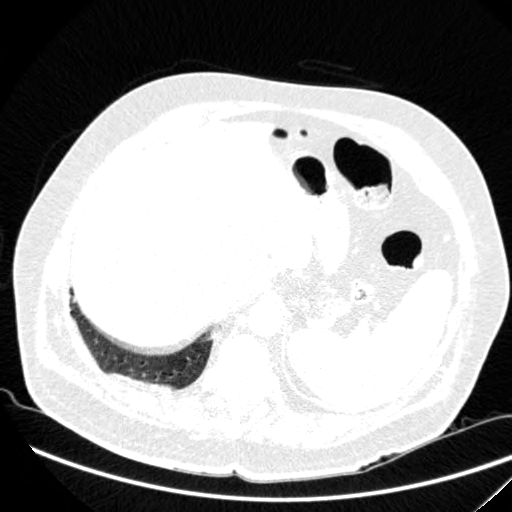

In [11]:
#@title Render a single slice
SLICE_TO_RENDER = 30
example_dicom = pydicom.dcmread(io.BytesIO(volume_as_bytes[SLICE_TO_RENDER]))

arr_unsigned = example_dicom.pixel_array.copy()
arr_unsigned = arr_unsigned.astype(np.float32)
arr_unsigned[arr_unsigned <0] = 0
arr_unsigned[arr_unsigned >1000] = 1000
arr_unsigned = (arr_unsigned / 1000) * 255
arr_unsigned = arr_unsigned.astype(np.uint8)
Image.fromarray(arr_unsigned, mode='L')

## Call the API to compute embeddings for the selected volume.

**NOTE:** *The API can take up to 10 minutes to scale individual instances. If you get errors, wait and attempt them again.*

Errors results in a FAIL Status string instead of embeddings in the returned list.

**NOTE:** Up to 300 parallel requests can be made if the system is fully scaled. Please start at 50 and reduce requests if you are getting end point errors.

In [18]:
#@title Python methods to call CT Foundation's API.

from concurrent.futures import ThreadPoolExecutor
import dataclasses
import functools
import json
from typing import Any, Tuple
import google.auth
import google.auth.transport.requests
import numpy as np


@dataclasses.dataclass(eq=False, frozen=True)
class Response:
  """Response from a Vertex Endpoint."""

  status_code: int
  response_json: dict[str, Any] | None  # json_types.JSONObject


class Endpoint:
  """Calling utility for a Vertex Endpoint using default credentials."""

  def __init__(self):
    self._endpoint_url = (
        'https://us-central1-aiplatform.googleapis.com/v1/projects/'
        'hai-cd3-foundations/locations/us-central1/endpoints/300')

  def predict(
      self,
      instances=list[Any],
      parameters: dict[str, Any] | None = None,
      credentials: google.auth.credentials.Credentials | None = None,
  ) -> Response:
    """Calls the Vertex Endpoint with the given instances and parameters."""
    if credentials is None:
      credentials = google.auth.default()[0]
    session = google.auth.transport.requests.AuthorizedSession(
        credentials=credentials
    )
    response = session.post(
        self._endpoint_url + ':predict',
        json=(
            {'instances': instances}
            | ({'parameters': parameters} if parameters is not None else {})
        ),
        headers={
            'Content-Type': 'application/json',
        },
        timeout=400
    )
    try:
      response_json = response.json()
    except json.JSONDecodeError:
      # Not expected, handling in case server incorrectly returns non-JSON.
      response_json = None
    return Response(
        status_code=response.status_code,
        response_json=response_json,
    )


def call_single_batch(
    caller: Endpoint,
    credentials,
    urls: list[str],
    access_token: str
) -> list[Tuple[np.ndarray | str, str]]:
  """Handles calls for a single batch and returns embeddings."""
  return_data = []
  if not credentials.valid:
    credentials.refresh(google.auth.transport.requests.Request())
  instances = [{
      "dicom_path": a_url, "bearer_token": f"{access_token}"} for a_url in urls]
  returns = caller.predict(instances=instances)
  if returns.status_code != 200:
    for a_url in urls:
      return_data.append((f'FAIL STATUS {returns.status_code}', a_url))
    return return_data
  else:
    for i in range(len(returns.response_json['predictions'])):
      if returns.response_json['predictions'][i]['error_response']:
        return_data.append((
            returns.response_json['predictions'][i]['error_response'], urls[i]))
      else:
        embeddings = returns.response_json['predictions'][i][
            'embedding_result'
        ]['embedding']
        return_data.append((embeddings, urls[i]))
    return return_data


def get_ct_embbeddings(
    caller: Endpoint,
    credentials,
    urls: list[str],
    access_token: str,
    batch_size: int,
    parallel_size: int,
) -> list[Tuple[np.ndarray | str, str]]:
  """Handles calls and returns for parallel requests.

  Args:
    caller: CT foundation API caller.
    credentials: The credentials for the API.
    urls: List of urls to the DICOM store for series to run.
      This must be of length batch_size * parallel_size.
    access_token: Access token for the DICOM store.
    batch_size: The number of volumes to pass in a batch (max 5).
    parallel_size: The number of parallel calls.

  Returns:
    Tuple list of embeddings | errors and the corresponding urls from which
      the embeddings were computed.
  """
  assert batch_size < 6, 'Batch size must be 5 or less.'
  assert (
      len(urls) == batch_size * parallel_size
  ), 'Error in batch, parallel sizes versus requests'

  # Setup up parallel batches
  p_urls = []
  for i in range(parallel_size):
    p_urls.append(urls[i * batch_size : (i + 1) * batch_size])

  # Check for correct sizing
  assert len(p_urls) == parallel_size, 'Error in batch, parallel dimensions'

  call_batch = functools.partial(call_single_batch, caller, credentials)

  # Launch parallel calls
  with ThreadPoolExecutor(max_workers=parallel_size) as executor:
    futures = [
        executor.submit(call_batch, b_urls, access_token) for b_urls in p_urls
    ]
    results = [f.result() for f in futures]
  # Unpack results into a single list
  return_results = []
  for b_result in results:
    for a_result in b_result:
      return_results.append(a_result)
  return return_results


In [24]:
#@title Create a URL, token, and call the API for the DICOM volume

def create_lidc_series_url(study_instance_uid, series_instance_uid):
  """Create a URL to the specific LIDC DICOM volume."""
  return ('https://healthcare.googleapis.com/v1/projects/ctpe-442718/'
          'locations/us-central1/datasets/ctpe-dicom-test/dicomStores/ctpe-dicom-sample/dicomWeb/'
          f'studies/{study_instance_uid}/series/{series_instance_uid}')

# Credentials to access the API
credentials = google.auth.default()[0]

# Token to access the DICOMs in the DICOM store
TOKEN_ = !gcloud beta auth application-default print-access-token
TOKEN = TOKEN_[0]

# The url pointing to the specific DICOM series that can be accessed via
# the above token.
my_url = create_lidc_series_url(study_uids[VOLUME_TO_SHOW],
                                corresponding_series_uids[VOLUME_TO_SHOW])

# Call the API with a single call and a batch size of 1.
my_embeddings = get_ct_embbeddings(
    caller=Endpoint(), credentials=credentials, urls=[my_url],
    access_token=TOKEN, batch_size=1, parallel_size=1)
# Total passed urls are 1
print(f'Embeddings or error message for the CT in the DICOM store at: {my_embeddings[0][1]}')
print(my_embeddings[0][0])



Embeddings or error message for the CT in the DICOM store at: https://healthcare.googleapis.com/v1/projects/ctpe-442718/locations/us-central1/datasets/ctpe-dicom-test/dicomStores/ctpe-dicom-sample/dicomWeb/studies/1.2.826.0.1.3680043.8.498.81650223882424085759492305405651094780/series/1.2.826.0.1.3680043.8.498.18823731631106926510958619169699558142
[0.1448660790920258, -0.8967000842094421, -0.1841428726911545, 1.733821153640747, -1.636698961257935, -0.2987595200538635, -1.25947093963623, -0.9567345976829529, -1.170474171638489, -0.6409149765968323, -0.6874585151672363, -0.5414289832115173, 0.5803607702255249, -0.00990352500230074, -0.6632899641990662, -1.119406342506409, -0.1145533099770546, 2.530545234680176, 1.055132508277893, -0.671112060546875, 0.7850156426429749, -0.6382920145988464, -1.868419051170349, -0.4895270466804504, 2.205286741256714, 1.333941578865051, -1.948273897171021, -0.6745303869247437, -0.3716036975383759, 1.321667432785034, 1.10100793838501, 0.6953431963920593, 0.

In [26]:
import pandas as pd

In [29]:
print(my_embeddings)
# df_embeddings = pd.DataFrame(my_embeddings)
# df_embeddings.to_csv('embeddings.csv',  index=False)

[([0.1448660790920258, -0.8967000842094421, -0.1841428726911545, 1.733821153640747, -1.636698961257935, -0.2987595200538635, -1.25947093963623, -0.9567345976829529, -1.170474171638489, -0.6409149765968323, -0.6874585151672363, -0.5414289832115173, 0.5803607702255249, -0.00990352500230074, -0.6632899641990662, -1.119406342506409, -0.1145533099770546, 2.530545234680176, 1.055132508277893, -0.671112060546875, 0.7850156426429749, -0.6382920145988464, -1.868419051170349, -0.4895270466804504, 2.205286741256714, 1.333941578865051, -1.948273897171021, -0.6745303869247437, -0.3716036975383759, 1.321667432785034, 1.10100793838501, 0.6953431963920593, 0.6930559277534485, 1.80716860294342, -0.8064472675323486, -1.708326578140259, -0.7543610334396362, 0.4440281391143799, -0.3629248440265656, 0.4238089323043823, 1.335086584091187, -0.2504888772964478, 0.1749378442764282, 0.6347672343254089, -0.9254948496818542, -1.24323308467865, -0.1981023848056793, -0.06410210579633713, -11.01711177825928, -1.8382

# Trying CT Foundation on your own CT DICOMs


1.   [Create your own DICOM store](https://cloud.google.com/healthcare-api/docs/)
2.   Upload your DICOMs to the store.
3.   Call the API for a given study / series in your DICOM store.
4.   Collect and store your embeddings for training.

**NOTE**: If performing parallel calls, i.e. parallel_size >1, please start at
50 or less as a start.

If you have any feedback or questions please email us at: ct-foundation@google.com


